##**Mild 1: Enhanced Preprocessing for Recipe Generation based on baseline 2 model**

###**Extension Overview**
In this Mild Extension 1, we enhanced the Baseline 2 sequence-to-sequence model with attention by implementing comprehensive domain-specific preprocessing techniques focused on recipe text normalization and vocabulary optimization. The primary goal was to improve the model's ability to understand and generate cooking recipes by processing the input and output data more effectively.

###**Key Enhancements Over Baseline 2**

####1. Advanced Text Normalization:
a. Implemented stemming and lemmatization using NLTK to reduce vocabulary complexity

b. Applied stopword removal to focus on content-bearing words

c. Created specialized cleaning functions for recipe ingredient lists and steps

####2. Domain-Specific Processing:

a. Developed comprehensive measurement unit removal for ingredients (cups, teaspoons, etc.)

b. Removed numeric quantities (whole numbers, fractions, decimals) from ingredients

c. Added structural tagging with <ingredient> and <step> markers to enhance recipe structure learning

####3. Vocabulary Optimization:

a. Implemented vocabulary pruning with different thresholds for input (3) and output (5) vocabularies

b. Reduced vocabulary size while preserving essential cooking terminology

c. Enhanced handling of unknown words to improve model robustness



###**Results and Analysis**
While our enhanced preprocessing approach produced semantically coherent recipes (indicated by the relatively high BERTScore of 0.7976), the BLEU-4 score of 0.0116 did not achieve the target 10% improvement over the baseline. The generated recipes were concise and generally captured the core recipe concepts, but often lacked the fluency and detail found in reference recipes.

The aggressive preprocessing likely contributed to lower lexical overlap with reference texts, affecting n-gram based metrics like BLEU, while preserving core semantic meaning. This suggests that finding the right balance between vocabulary reduction and maintaining linguistic structure will be crucial for further improvements.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/ColabNotebooks/Cooking_Dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- 1. IMPORTS ORGANIZATION ---
import os
import json
import re
import time
import math
import random
from io import open
import unicodedata
import string
from collections import Counter

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud

!pip install nltk bert-score
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score

import logging
import transformers
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

In [ ]:
# --- 2. CONSOLIDATED HYPERPARAMETERS ---
# Special tokens
SOS_token = 0
EOS_token = 1
UNK_token = 2
PAD_token = 3

# Model hyperparameters
MAX_LENGTH = 100
HIDDEN_SIZE = 256
BATCH_SIZE = 16
LEARNING_RATE = 0.001
TEACHER_FORCING_RATIO = 0.5
NUM_EPOCHS = 30
PRINT_EVERY = 625
PLOT_EVERY = 625
PATIENCE = 5

# Enhanced preprocessing parameters
MIN_WORD_COUNT_INPUT = 3  # Minimum count for ingredients vocabulary
MIN_WORD_COUNT_OUTPUT = 5  # Minimum count for recipes vocabulary

# Training data limitation
MAX_TRAIN_SAMPLES = 10000  # Only use first 10000 samples from training set

# Development mode flag
USE_SMALL_TEST = False  # Use a small test set during development

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# --- 3. ENHANCED PREPROCESSING SETUP ---
# Initialize NLTK components
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Define cooking units
UNITS = ['cup', 'cups', 'teaspoon', 'teaspoons', 'tablespoon', 'tablespoons',
         'tsp', 'tbsp', 'oz', 'ounce', 'ounces', 'pound', 'lb', 'pkg', 'package',
         'g', 'gram', 'grams', 'kg', 'ml', 'l', 'liter', 'liters', 'pinch', 'dash',
         'quart', 'quarts', 'inch', 'inches', 'slice', 'slices', 'can', 'cans']

# --- 4. ENHANCED PREPROCESSING FUNCTIONS ---
def clean_ingredient(ingredient_str):
    """Clean and normalize a single ingredient string"""
    # Convert to lowercase
    ingredient_str = ingredient_str.lower()

    # Split into tokens
    tokens = ingredient_str.split()

    # Remove numbers, fractions, and decimals
    tokens = [t for t in tokens if not re.match(r'^\d+\/?\d*$', t) and not re.match(r'^\d+\.\d+$', t)]

    # Remove cooking units
    tokens = [t for t in tokens if t not in UNITS]

    # Remove stopwords
    tokens = [t for t in tokens if t not in STOPWORDS]

    # Apply lemmatization
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # Apply stemming
    tokens = [stemmer.stem(t) for t in tokens]

    # Rejoin tokens
    return ' '.join(tokens)

def process_ingredients(ingredients_list):
    """Process a list of ingredients, adding structure tags"""
    cleaned = [f"<ingredient>{clean_ingredient(i)}</ingredient>" for i in ingredients_list]
    return ' '.join(cleaned)

def clean_step(text):
    """Clean and normalize a recipe step"""
    # Convert to lowercase
    text = text.lower()

    # Keep only alphanumeric and certain punctuation
    text = re.sub(r"[^a-z0-9.,:/'\"()%-]+", ' ', text)

    # Split into tokens
    tokens = text.split()

    # Remove stopwords
    tokens = [t for t in tokens if t not in STOPWORDS]

    # Apply lemmatization
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # Apply stemming
    tokens = [stemmer.stem(t) for t in tokens]

    # Rejoin tokens
    return ' '.join(tokens)

def process_recipe(steps_list):
    """Process a list of recipe steps, adding structure tags"""
    cleaned = [f"<step>{clean_step(s)}</step>" for s in steps_list]
    return ' '.join(cleaned)

# --- 5. ENHANCED DATA LOADING ---
def loadData(file_path, file_name, preprocess=True):
    """Load and preprocess recipe data"""
    print(f"Loading data from {file_path}/{file_name}")
    data = pd.read_csv(f"{file_path}/{file_name}")

    # Print sample of original data
    print(f"\nOriginal data from {file_name} (first 3 rows):")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 150)
    pd.set_option('display.max_colwidth', 100)
    print(data.head(3))

    # Convert ingredients from string to list
    data['Ingredients'] = data['Ingredients'].apply(eval)

    # For test data, we might need to handle recipes differently
    if 'Recipe' in data.columns:
        # Check if Recipe is already a list (test data might have string format)
        first_recipe = data['Recipe'].iloc[0]
        if isinstance(first_recipe, str) and first_recipe.startswith('['):
            # Convert string representation to list
            data['Recipe'] = data['Recipe'].apply(eval)
        elif isinstance(first_recipe, str):
            # If it's just a string, convert to single-item list
            data['Recipe'] = data['Recipe'].apply(lambda x: [x])

    # Create raw joined text (for backward compatibility)
    data['Ingredients_text'] = data['Ingredients'].apply(lambda x: ' '.join(x))

    # Apply enhanced preprocessing
    if preprocess:
        # Apply our enhanced preprocessing
        data['Ingredients_processed'] = data['Ingredients'].apply(process_ingredients)
        if 'Recipe' in data.columns:
            data['Recipe_processed'] = data['Recipe'].apply(process_recipe)

        # Print sample of processed data
        print(f"\nProcessed data from {file_name} (first 3 rows):")
        if 'Recipe' in data.columns:
            print(data[['Ingredients_processed', 'Recipe_processed']].head(3))
        else:
            print(data[['Ingredients_processed']].head(3))

    # Reset pandas display options
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

    return data

In [ ]:
# --- 6. ENHANCED LANGUAGE CLASS WITH PRUNING ---
class Lang:
    def __init__(self, name, min_word_count=1):
        self.name = name
        self.word2index = {"SOS": SOS_token, "EOS": EOS_token, "UNK": UNK_token, "PAD": PAD_token}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK", PAD_token: "PAD"}
        self.n_words = 4  # Count SOS, EOS, UNK and PAD
        self.min_word_count = min_word_count
        self.pruned = False

    def addSentence(self, sentence):
        """Add all words in a sentence to vocabulary"""
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        """Add a single word to vocabulary"""
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def prune(self):
        """Remove words below frequency threshold"""
        if self.pruned:
            return

        print(f"Pruning {self.name} vocabulary... ", end="")
        original_count = len(self.word2count)

        # Identify words to keep
        kept_words = {w for w, c in self.word2count.items() if c >= self.min_word_count}

        # Rebuild vocabulary
        self.word2index = {"SOS": SOS_token, "EOS": EOS_token, "UNK": UNK_token, "PAD": PAD_token}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK", PAD_token: "PAD"}
        self.n_words = 4

        new_counts = {}
        for w in kept_words:
            self.word2index[w] = self.n_words
            self.index2word[self.n_words] = w
            new_counts[w] = self.word2count[w]
            self.n_words += 1

        self.word2count = new_counts
        self.pruned = True

        print(f"Reduced from {original_count} to {len(self.word2count)} words")


In [ ]:
# --- 7. TENSOR CREATION FUNCTIONS ---
def indexesFromSentence(lang, sentence):
    """Convert a sentence to a list of indices"""
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence, max_length=MAX_LENGTH):
    """Convert a sentence to a tensor with padding"""
    indexes = indexesFromSentence(lang, sentence)

    # Truncate if too long
    if len(indexes) > max_length - 1:  # -1 to account for EOS token
        indexes = indexes[:max_length-1]

    # Add EOS token
    indexes.append(EOS_token)

    # Pad if too short
    padding = [PAD_token] * (max_length - len(indexes))
    indexes.extend(padding)

    return torch.tensor(indexes, dtype=torch.long, device=device)

In [ ]:
# --- 8. RECIPE DATASET CLASS ---
class RecipeDataset(Dataset):
    def __init__(self, data, input_lang, output_lang, max_length=MAX_LENGTH):
        self.data = data
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ingredients = self.data.iloc[idx]['Ingredients_processed']
        recipe = self.data.iloc[idx]['Recipe_processed']

        input_tensor = tensorFromSentence(self.input_lang, ingredients, self.max_length)
        target_tensor = tensorFromSentence(self.output_lang, recipe, self.max_length)

        return input_tensor, target_tensor

In [ ]:
# --- MAIN EXECUTION BLOCK ---
# Load and preprocess data
train_data = loadData(file_path, "train.csv", preprocess=True)
dev_data = loadData(file_path, "dev.csv", preprocess=True)
test_data = loadData(file_path, "test.csv", preprocess=False)

# Limit training data if needed
train_data_limited = train_data.iloc[:MAX_TRAIN_SAMPLES].copy()
print(f"\nUsing the first {len(train_data_limited)} samples from the training set")
print(f"This is {len(train_data_limited)/len(train_data)*100:.1f}% of the complete training set")

# Create vocabularies with pruning
input_lang = Lang("ingredients", min_word_count=MIN_WORD_COUNT_INPUT)
output_lang = Lang("recipes", min_word_count=MIN_WORD_COUNT_OUTPUT)

# Add words from limited training data to vocabularies
print("Creating vocabularies from limited training data...")
for i, row in train_data_limited.iterrows():
    input_lang.addSentence(row['Ingredients_processed'])
    output_lang.addSentence(row['Recipe_processed'])

# Apply vocabulary pruning
input_lang.prune()
output_lang.prune()

# Create datasets and dataloaders
train_dataset = RecipeDataset(train_data_limited, input_lang, output_lang)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

dev_dataset = RecipeDataset(dev_data, input_lang, output_lang)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)

# Print vocabulary stats after pruning
print(f"Final input vocabulary size: {input_lang.n_words} words")
print(f"Final output vocabulary size: {output_lang.n_words} words")

Loading data from /content/drive/MyDrive/ColabNotebooks/Cooking_Dataset/train.csv

Original data from train.csv (first 3 rows):
                  Title                                                                                          Ingredients  \
0   No-Bake Nut Cookies  ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken ...   
1           Creamy Corn  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg. cream cheese, cubed", "1/3 c. butter, cubed", "1...   
2  Reeses Cups(Candy)    ["1 c. peanut butter", "3/4 c. graham cracker crumbs", "1 c. melted butter", "1 lb. (3 1/2 c.) p...   

                                                                                                Recipe  
0  ["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.",...  
1  ["In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated t...  
2  ["Combine first four ingredients and pres

In [ ]:
# --- 9. ENCODER MODEL ---
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden):
        # Forward pass through the encoder
        batch_size = input.size(0)

        # Embedding: [batch_size, seq_len] -> [batch_size, seq_len, hidden_size]
        embedded = self.embedding(input)

        # Initialize hidden if None
        if hidden is None:
            hidden = self.initHidden(batch_size)

        # GRU forward pass
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# --- 10. DECODER MODEL ---
# --- Attention Mechanism ---
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [1, batch_size, hidden_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]

        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)

        # Reshape hidden to prepare for concatenation
        # [1, batch_size, hidden_size] -> [batch_size, 1, hidden_size]
        hidden = hidden.transpose(0, 1)

        # Repeat hidden state across sequence length
        # [batch_size, 1, hidden_size] -> [batch_size, seq_len, hidden_size]
        hidden = hidden.repeat(1, seq_len, 1)

        # Concatenate hidden state with each encoder output
        # [batch_size, seq_len, hidden_size * 2]
        concat = torch.cat((hidden, encoder_outputs), dim=2)

        # Calculate energy
        # [batch_size, seq_len, hidden_size]
        energy = torch.tanh(self.attn(concat))

        # Calculate attention weights
        # [batch_size, seq_len, 1] -> [batch_size, seq_len]
        attention = self.v(energy).squeeze(2)

        # Apply softmax to get attention weights summing to 1
        # [batch_size, seq_len]
        return F.softmax(attention, dim=1)

class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = Attention(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(self.dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden, encoder_outputs):
        # input: [batch_size] or [batch_size, 1]
        # hidden: [1, batch_size, hidden_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]

        # Ensure input has batch_first dimension
        if input.dim() == 1:
            input = input.unsqueeze(1)  # [batch_size] -> [batch_size, 1]

        # Embed input
        embedded = self.embedding(input)  # [batch_size, 1, hidden_size]
        embedded = self.dropout(embedded)

        # Calculate attention weights
        attn_weights = self.attention(hidden, encoder_outputs)  # [batch_size, seq_len]

        # Create context vector by applying attention weights to encoder outputs
        # [batch_size, 1, seq_len] x [batch_size, seq_len, hidden_size] = [batch_size, 1, hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)

        # Combine embedded input and context vector
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, hidden_size*2]

        # GRU forward pass
        output, hidden = self.gru(rnn_input, hidden)  # [batch_size, 1, hidden_size]

        # Apply output layer
        output = self.out(output)  # [batch_size, 1, output_size]

        # Apply log softmax
        output = self.softmax(output)  # [batch_size, 1, output_size]

        return output, hidden, attn_weights

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# Initialize models
encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
attention_decoder = AttentionDecoderRNN(HIDDEN_SIZE, output_lang.n_words).to(device)

# Define optimizer and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.Adam(attention_decoder.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss(ignore_index=PAD_token, reduction='sum')

In [ ]:
# --- 11. TRAINING FUNCTION ---
def train_batch_attention(input_batch, target_batch, encoder, decoder,
                         encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Train the model on a single batch with attention
    batch_size = input_batch.size(0)

    # Zero the gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Initialize loss
    loss = 0

    # Initialize encoder hidden state
    encoder_hidden = encoder.initHidden(batch_size)

    # Process the input batch through the encoder
    encoder_outputs, encoder_hidden = encoder(input_batch, encoder_hidden)

    # First decoder input is the SOS token for each item in the batch
    decoder_input = torch.tensor([SOS_token] * batch_size, device=device)

    # Set decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden

    # Determine whether to use teacher forcing
    use_teacher_forcing = True if random.random() < TEACHER_FORCING_RATIO else False

    # Teacher forcing: use the ground-truth target as the next input
    if use_teacher_forcing:
        for di in range(target_batch.size(1)):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)

            # Calculate loss for the current timestep
            loss += criterion(decoder_output.squeeze(1), target_batch[:, di])

            # Next input is current target
            decoder_input = target_batch[:, di]

    # Without teacher forcing: use decoder's own prediction as the next input
    else:
        for di in range(target_batch.size(1)):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)

            # Get the most likely word index
            topv, topi = decoder_output.squeeze(1).topk(1)
            decoder_input = topi.squeeze(1).detach()  # Detach from history as input

            # Calculate loss
            loss += criterion(decoder_output.squeeze(1), target_batch[:, di])

            # Stop if all sequences in batch reached EOS
            if (decoder_input == EOS_token).all():
                break

    # Backpropagate
    loss.backward()

    # Clip gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1)

    # Update weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / batch_size

In [ ]:
# --- 12. EVALUATION FUNCTION ---
def evaluate_attention(encoder, decoder, ingredients_text, max_length=MAX_LENGTH):
    """Generate a recipe from ingredients using the trained model with attention"""
    with torch.no_grad():
        # Process the input sentence using the enhanced preprocessing
        # First, make it a list if it's not already
        if isinstance(ingredients_text, str):
            # If it's just a single string of ingredients
            ingredients_list = ingredients_text.split(', ')
        else:
            # Already a list
            ingredients_list = ingredients_text

        # Apply the enhanced preprocessing
        processed_ingredients = process_ingredients(ingredients_list)

        # Create a list of indices from the sentence and add EOS
        indexes = [input_lang.word2index.get(word, UNK_token) for word in processed_ingredients.split(' ')]
        if len(indexes) > max_length - 1:
            indexes = indexes[:max_length-1]
        indexes.append(EOS_token)

        # Create input tensor [seq_len]
        input_tensor = torch.tensor(indexes, dtype=torch.long, device=device)

        # Add batch dimension [1, seq_len]
        input_tensor = input_tensor.unsqueeze(0)

        # Initialize encoder hidden state
        encoder_hidden = encoder.initHidden(1)

        # Pass through the encoder
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        # Initialize decoder input - single SOS token
        decoder_input = torch.tensor([[SOS_token]], device=device)  # [1, 1]

        decoder_hidden = encoder_hidden

        decoded_words = []

        # Step-by-step decoding
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            # Get the word with highest probability
            topv, topi = decoder_output.topk(1, dim=2)
            topi = topi.squeeze(-1)  # Remove the last dimension

            # Get word index
            word_idx = topi.item() if topi.numel() == 1 else topi[0].item()

            # Handle special tokens
            if word_idx == EOS_token:
                decoded_words.append('<EOS>')
                break
            elif word_idx == PAD_token:
                continue
            else:
                if word_idx < len(output_lang.index2word):
                    word = output_lang.index2word[word_idx]
                    decoded_words.append(word)
                else:
                    unk_word = f"<UNK-{word_idx}>"
                    decoded_words.append(unk_word)

            # Prepare the next input - keep shape [1, 1]
            decoder_input = torch.tensor([[word_idx]], device=device)

        # Combine the result
        result = ' '.join([word for word in decoded_words if word != '<EOS>'])
        return result

# --- 13. DEVELOPMENT EVALUATION FUNCTION ---
def develop_attention(encoder, decoder, dataloader, criterion, max_length=MAX_LENGTH):
    # Evaluate the model on the development set with attention
    encoder.eval()
    decoder.eval()

    total_loss = 0
    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(dataloader):
            batch_size = input_batch.size(0)

            # Initialize encoder hidden state
            encoder_hidden = encoder.initHidden(batch_size)

            # Process the input batch through the encoder
            encoder_outputs, encoder_hidden = encoder(input_batch, encoder_hidden)

            # First decoder input is the SOS token for each item in the batch
            decoder_input = torch.tensor([SOS_token] * batch_size, device=device)

            # Set decoder hidden state to the encoder's final hidden state
            decoder_hidden = encoder_hidden

            # Initialize loss
            loss = 0

            # Decode one step at a time
            for di in range(target_batch.size(1)):
                decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)

                # Calculate loss
                loss += criterion(decoder_output.squeeze(1), target_batch[:, di])

                # Next input is ground truth
                decoder_input = target_batch[:, di]

            total_loss += loss.item() / batch_size

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [ ]:
# --- 14. TRAINING LOOP ---
def train_epochs_attention(encoder, decoder, train_dataloader, dev_dataloader,
                         encoder_optimizer, decoder_optimizer, criterion,
                         num_epochs, print_every=PRINT_EVERY, plot_every=PLOT_EVERY):
    # Train the model for multiple epochs with attention
    start = time.time()
    train_losses = []
    dev_losses = []
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    best_dev_loss = float('inf')

    # Early Stopping
    patience = PATIENCE
    no_improve_count = 0

    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()

        epoch_loss = 0
        batch_count = 0

        for i, (input_batch, target_batch) in enumerate(train_dataloader):
            batch_count += 1

            # Train on this batch
            loss = train_batch_attention(input_batch, target_batch, encoder, decoder,
                             encoder_optimizer, decoder_optimizer, criterion)

            # Accumulate loss
            print_loss_total += loss
            plot_loss_total += loss
            epoch_loss += loss

            # Update plot
            if batch_count % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} complete | Average Loss: {avg_epoch_loss:.4f}")

        # Develop
        dev_loss = develop_attention(encoder, decoder, dev_dataloader, criterion)
        print(f"Development Loss: {dev_loss:.4f}")

        # Store losses for plotting
        train_losses.append(avg_epoch_loss)
        dev_losses.append(dev_loss)

        # Early Stopping
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            no_improve_count = 0
            print(f"New best development loss: {dev_loss:.4f}")

            # Save best model
            torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
            }, f"{file_path}/Mild1_best_model.pt")
            print("Best model saved.")
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

    # Show the loss plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, len(dev_losses) + 1), dev_losses, 'r-', label='Development Loss')
    plt.title('Training and Development Loss (with Attention)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{file_path}/loss_plot_attention.png")
    plt.show()

    time_taken = time.time() - start
    print(f"Training completed in {time_taken/60:.2f} minutes")

    return train_losses, dev_losses

In [ ]:
# --- 15. EVALUATION METRICS ---
def calculate_metrics(reference, hypothesis):
    # Calculate BLEU-4, METEOR, and BERTScore metrics
    try:
        # Tokenize for metrics calculation
        ref_tokens = nltk.word_tokenize(reference)
        hyp_tokens = nltk.word_tokenize(hypothesis)

        # BLEU-4 with smoothing
        smoothie = SmoothingFunction().method4
        bleu = sentence_bleu([ref_tokens], hyp_tokens,
                            weights=(0.25, 0.25, 0.25, 0.25),
                            smoothing_function=smoothie)

        # METEOR
        meteor = meteor_score([ref_tokens], hyp_tokens)

        # BERTScore
        P, R, F1 = bert_score([hypothesis], [reference], lang='en', verbose=False)
        bertscore = F1.numpy().item()

        return bleu, meteor, bertscore

    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return 0.0, 0.0, 0.0


Starting training with attention...
Epoch 1/30 complete | Average Loss: 143.2010
Development Loss: 123.7332
New best development loss: 123.7332
Best model saved.
Epoch 2/30 complete | Average Loss: 138.1502
Development Loss: 121.0206
New best development loss: 121.0206
Best model saved.
Epoch 3/30 complete | Average Loss: 132.1150
Development Loss: 118.6180
New best development loss: 118.6180
Best model saved.
Epoch 4/30 complete | Average Loss: 129.0729
Development Loss: 117.6412
New best development loss: 117.6412
Best model saved.
Epoch 5/30 complete | Average Loss: 126.8902
Development Loss: 118.3606
Epoch 6/30 complete | Average Loss: 123.3870
Development Loss: 119.0182
Epoch 7/30 complete | Average Loss: 120.2706
Development Loss: 118.6910
Epoch 8/30 complete | Average Loss: 117.1696
Development Loss: 119.2393
Epoch 9/30 complete | Average Loss: 114.7799
Development Loss: 119.1099
Early stopping after 9 epochs


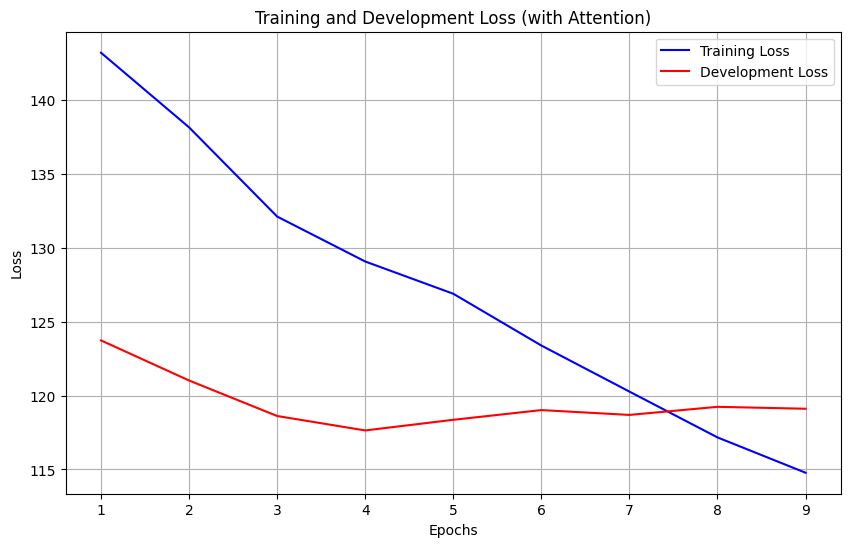

Training completed in 22.89 minutes


([143.20104626464843,
  138.15022747192384,
  132.11501231689454,
  129.07285338134767,
  126.8902494506836,
  123.38701174926757,
  120.27055635986328,
  117.16955103759766,
  114.77989533691407],
 [123.7332069181882,
  121.02064077652508,
  118.61801358755945,
  117.64119428188647,
  118.36058613791394,
  119.01818265646052,
  118.69096316310699,
  119.23926068459379,
  119.10994233341755])

In [ ]:
# --- 16. MAIN EXECUTION BLOCK ---
# Start training
print("\nStarting training with attention...")
train_epochs_attention(
    encoder, attention_decoder, train_dataloader, dev_dataloader,
    encoder_optimizer, decoder_optimizer, criterion,
    NUM_EPOCHS, PRINT_EVERY, PLOT_EVERY
)

In [ ]:
# Save final model
torch.save({
   'encoder_state_dict': encoder.state_dict(),
   'decoder_state_dict': attention_decoder.state_dict(),
}, f"{file_path}/Mild1_final_model.pt")
print("Final model saved.")

Final model saved.


In [ ]:
# Evaluate on test data
print("\nEvaluating Mild Extension 1 model on test data...")

# Decide whether to use a subset of test data for evaluation
if USE_SMALL_TEST:
   # Use only the first 10 samples
   test_subset = test_data[:10]
   print(f"Using {len(test_subset)} test samples for evaluation (development mode)")
else:
   # Use all test data
   test_subset = test_data
   print(f"Using all {len(test_data)} test samples for evaluation (production mode)")

# Set models to evaluation mode
encoder.eval()
attention_decoder.eval()

# Initialize lists to store results
test_results = []
bleu_scores = []
meteor_scores = []
bertscore_scores = []

def process_recipe_for_evaluation(recipe_text):
    """Process recipe text to be compatible with our evaluation metrics"""
    if isinstance(recipe_text, list):
        # If it's a list of steps, join them
        recipe_text = ' '.join(recipe_text)

    # Clean the text but keep essential structure for metric calculation
    # Don't apply full preprocessing as we need to compare with original
    recipe_text = recipe_text.lower()
    recipe_text = re.sub(r"[^a-z0-9.,:/'\"()%\s-]+", ' ', recipe_text)
    recipe_text = re.sub(r"\s+", ' ', recipe_text).strip()
    return recipe_text

# Process test data
for idx, row in test_subset.iterrows():
    # Get ingredients list
    ingredients_list = row['Ingredients']

    # Get original recipe (handle both string and list formats)
    if isinstance(row['Recipe'], list):
        original_recipe = ' '.join(row['Recipe'])
    else:
        original_recipe = row['Recipe']

    # Generate recipe using enhanced preprocessing
    generated_recipe = evaluate_attention(encoder, attention_decoder, ingredients_list)

    # Process both recipes for fair comparison
    processed_original = process_recipe_for_evaluation(original_recipe)
    processed_generated = process_recipe_for_evaluation(generated_recipe)

    # Remove tags from generated recipe for evaluation
    processed_generated = re.sub(r'<step>|</step>', '', processed_generated)

    # Calculate metrics
    try:
        bleu, meteor, bertscore = calculate_metrics(processed_original, processed_generated)
    except Exception as e:
        print(f"Error calculating metrics for sample {idx}: {str(e)}")
        bleu, meteor, bertscore = 0.0, 0.0, 0.0

    # Store results
    test_results.append({
        'ingredients': str(ingredients_list),  # Convert list to string for CSV
        'original_recipe': original_recipe,
        'generated_recipe': generated_recipe,
        'bleu': bleu,
        'meteor': meteor,
        'bertscore': bertscore
    })

    # Accumulate scores for averaging
    bleu_scores.append(bleu)
    meteor_scores.append(meteor)
    bertscore_scores.append(bertscore)

    # Print progress every 100 samples
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(test_subset)} test samples")

# Convert results to DataFrame
results_df = pd.DataFrame(test_results)

# Save results
results_df.to_csv(f"{file_path}/Mild1_results.csv", index=False)
print("Results saved to CSV file.")

# Calculate average metrics
avg_bleu = np.mean(bleu_scores)
avg_meteor = np.mean(meteor_scores)
avg_bertscore = np.mean(bertscore_scores)

print("\nMild Extension 1 Evaluation Results:")
print(f"BLEU-4 Score: {avg_bleu:.4f}")
print(f"METEOR Score: {avg_meteor:.4f}")
print(f"BERTScore (F1): {avg_bertscore:.4f}")


Evaluating Mild Extension 1 model on test data...
Using all 1081 test samples for evaluation (production mode)
Processed 100/1081 test samples
Processed 200/1081 test samples


Processed 300/1081 test samples


Processed 400/1081 test samples


Processed 500/1081 test samples


Processed 600/1081 test samples


Processed 700/1081 test samples


Processed 800/1081 test samples


Processed 900/1081 test samples


Processed 1000/1081 test samples


Results saved to CSV file.

Mild Extension 1 Evaluation Results:
BLEU-4 Score: 0.0116
METEOR Score: 0.0947
BERTScore (F1): 0.7976


In [ ]:
# Qualitative comparison test for presentation
print("\n=== Qualitative Comparison for Presentation (Attention Model) ===")

# Test Sample 1
sample1 = ["sugar", "lemon juice", "water", "orange juice", "strawberries", "icecream"]
result1 = evaluate_attention(encoder, attention_decoder, sample1)
words1 = " ".join(result1.split()[:30])
print("\nSample 1:")
print(f"Ingredients: {sample1}")
print(f"First 30 words: {words1}")

# Test Sample 2
sample2 = ["8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c lemon juice, 48 oz canned cherries, 8 inch graham cracker, pie crusts"]
result2 = evaluate_attention(encoder, attention_decoder, sample2)
words2 = " ".join(result2.split()[:30])
print("\nSample 2:")
print(f"Ingredients: {sample2}")
print(f"First 30 words: {words2}")

# Save
with open(f"{file_path}/qualitative_results_mild1.txt", "w") as f:
    f.write(f"Sample 1 (Mild 1): {words1}\n\n")
    f.write(f"Sample 2 (Mild 1): {words2}\n")

print("\nResults saved to file.")


=== Qualitative Comparison for Presentation (Attention Model) ===

Sample 1:
Ingredients: ['sugar', 'lemon juice', 'water', 'orange juice', 'strawberries', 'icecream']
First 30 words: <step>mix togeth pour jar seal.</step> <step>make 18 servings.</step>

Sample 2:
Ingredients: ['8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c lemon juice, 48 oz canned cherries, 8 inch graham cracker, pie crusts']
First 30 words: <step>sprinkl lemon juic pie crust.</step> <step>top cherri pie filling. chill least 4 hours).</step>

Results saved to file.
